# Deep_Learning_from_Scratch_2 - part7

#### 딥러닝의 기본적인 내용을 정리하였습니다. 밑바닥부터 시작하는 딥러닝2(사이토 고키 지음)을 참고하였습니다. 

## 8. 어텐션
### 8.1 어텐션의 구조
#### 8.1.1 seq2seq의 문제점
#### - seq2seq에서는 Encoder를 통해 고정 길이 벡터를 생성 -> 문장 길이에 상관없이 늘 같은 고정 길이 벡터를 생성
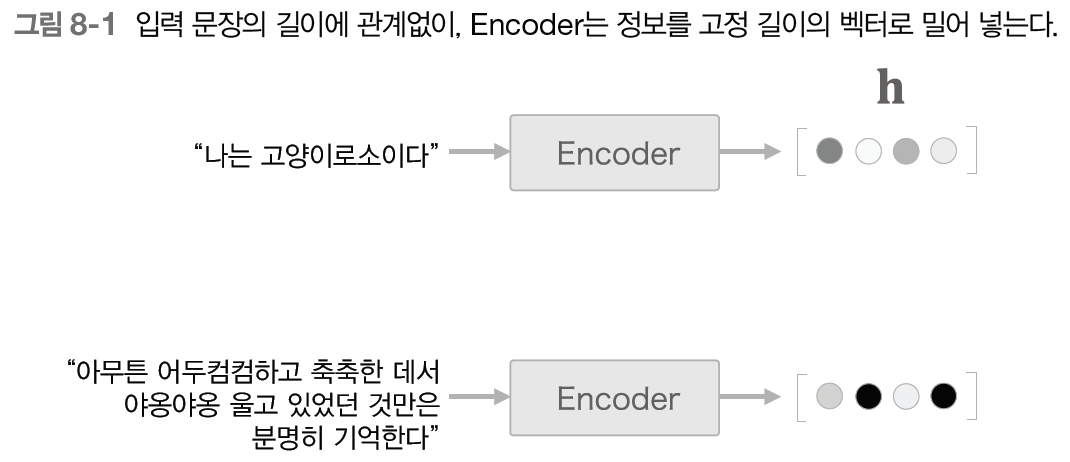
#### 8.1.2 Encoder 개선
#### - Encoder 출력의 길이를 입력 문장의 길이에 따라 변경, 시각별 LSTM 계층의 은닉 상태르 벡터를 모두 활용
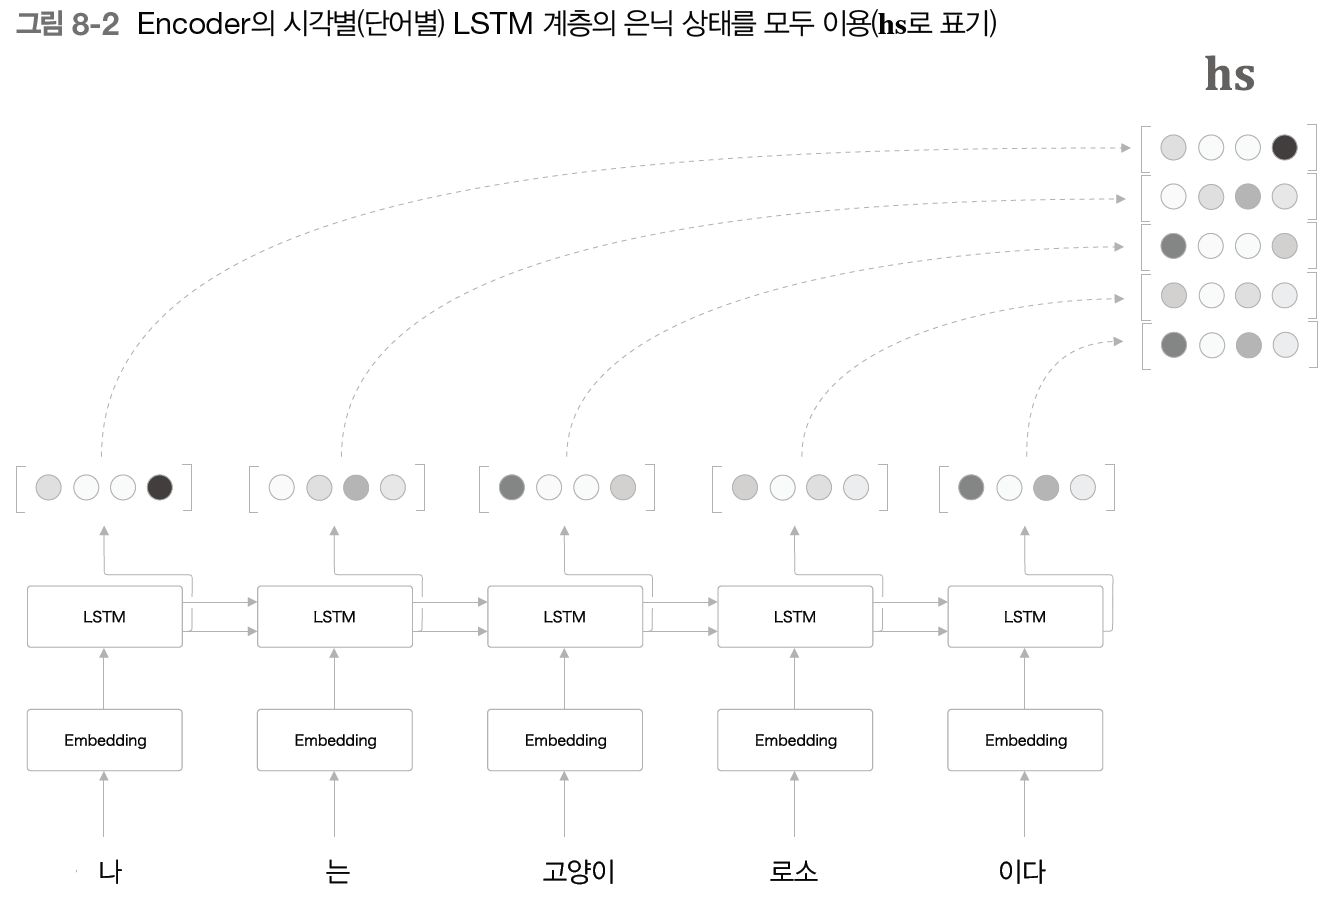
#### - 각 시각의 은닉 상태 : 직전에 입력된 단어에 대한 정보 포함 -> hs 행렬은 각 단어에 해당하는 벡터들의 집합
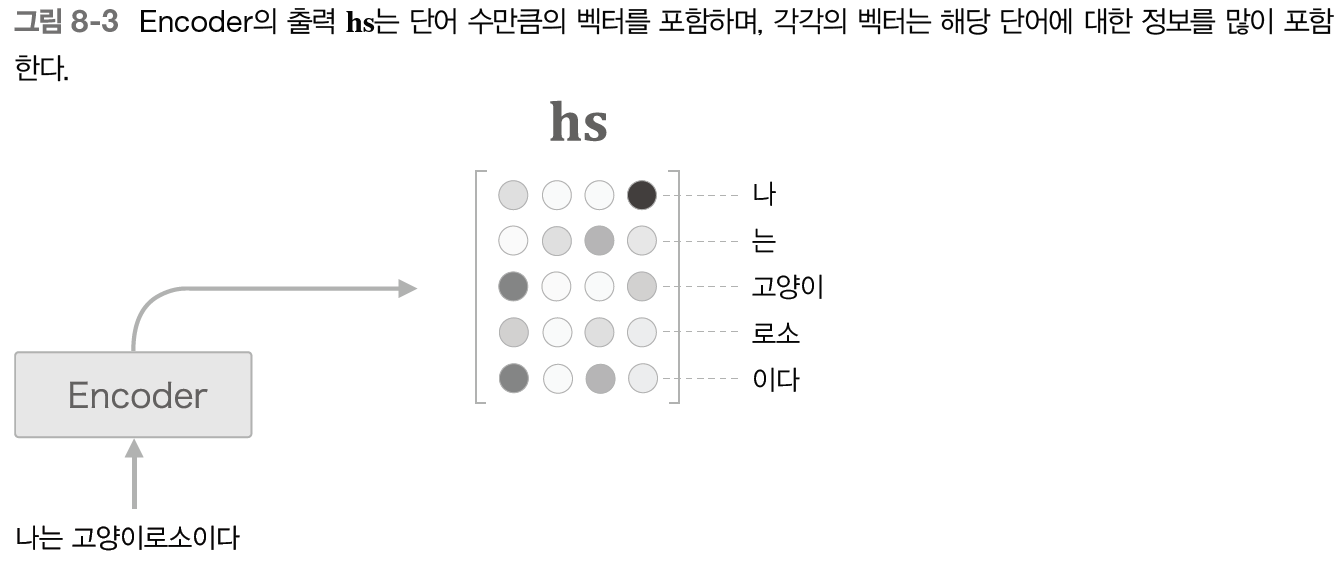
#### 8.1.3 Decoder 개선 1
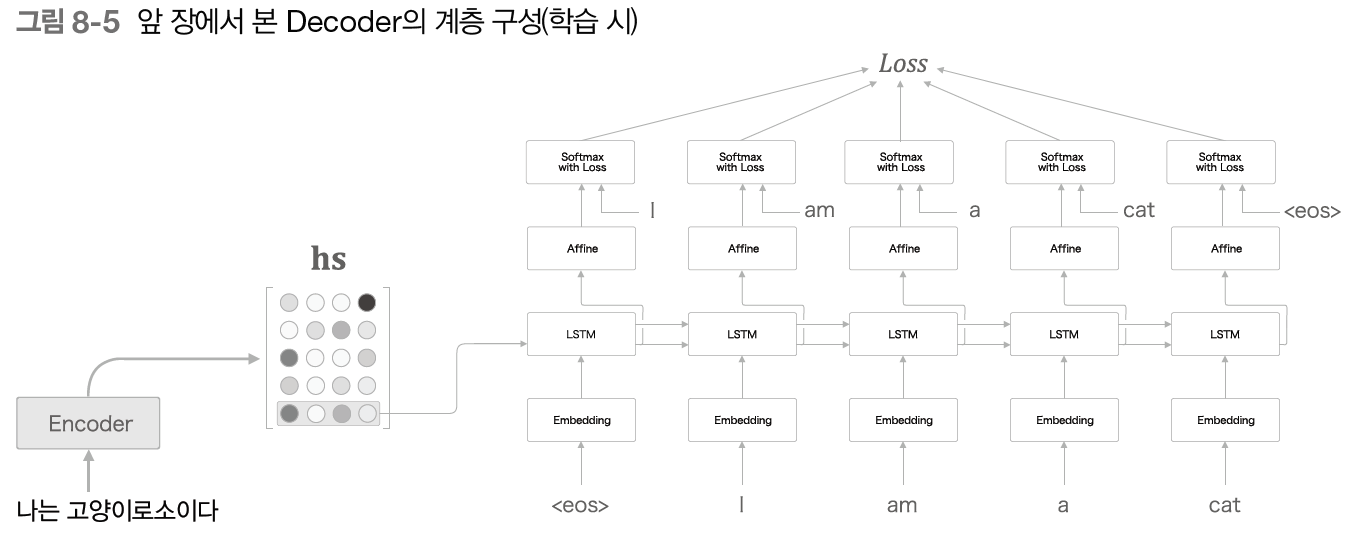
#### - 입력과 출력의 여러 단어 중 어떤 단어끼리 서로 관련되어 있는가에 집중 -> 도착어 단어와 대응관계에 있는 출발어 단어의 정보를 골라내는 것을 목표로 함
#### - 필요한 정보에만 주목하여 그 정보로부터 시계열 변환을 수행하는 것이 목표
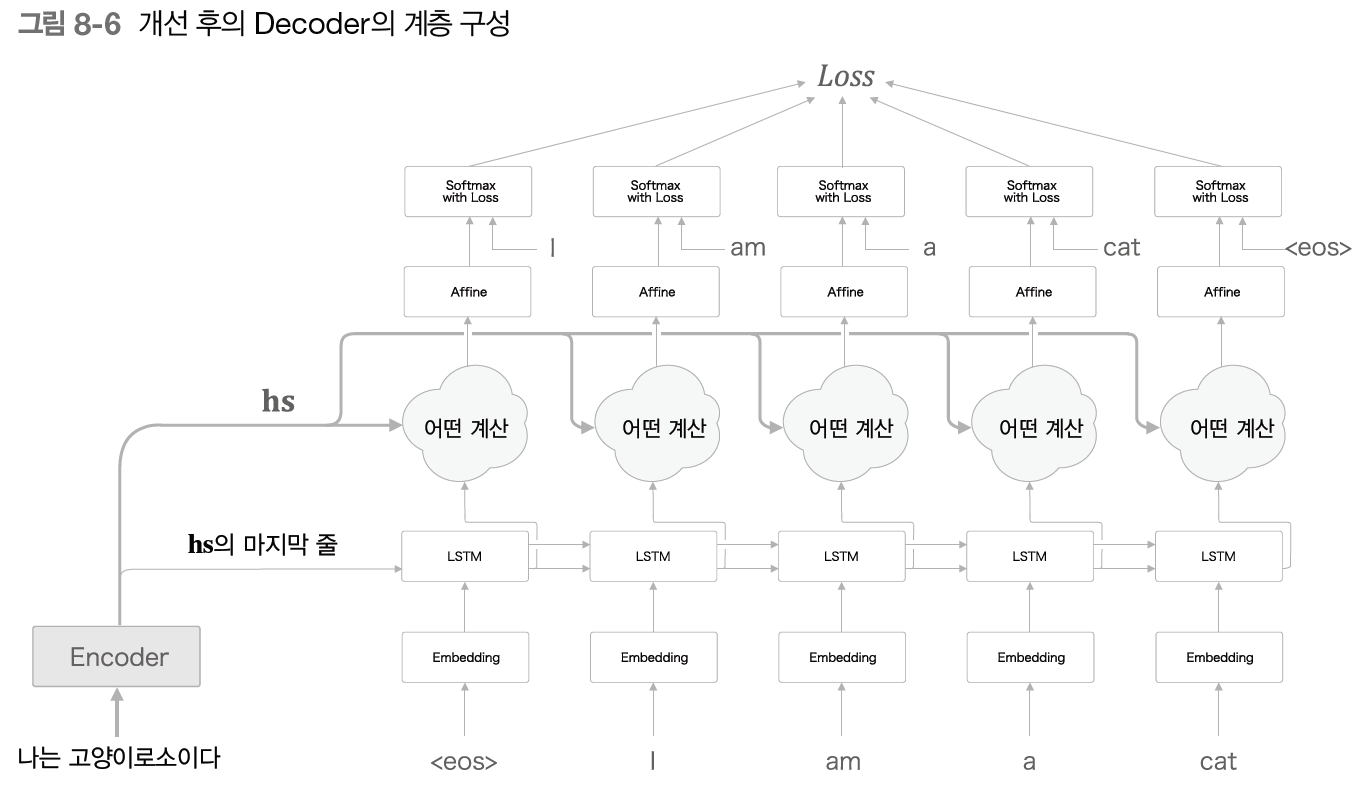
#### - '선택'이라는 행위는 미분이 불가능한 작업 -> 오차역전법 활용을 통한 학습이 불가능 -> 하나를 선택하는 것이 아닌 모든 것을 선택하여 가중치를 별도로 계산
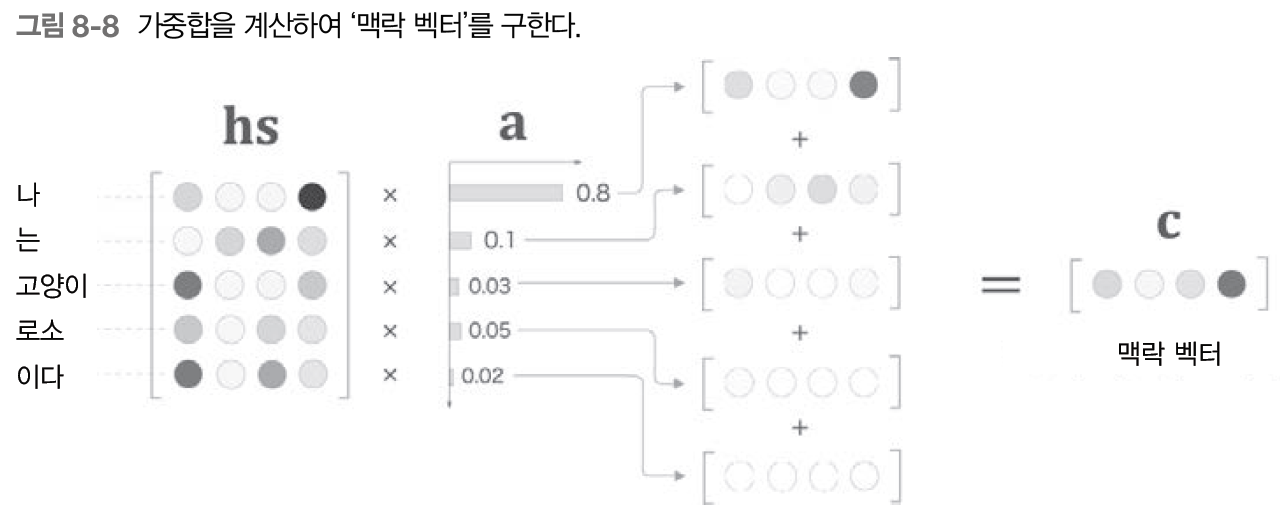

In [1]:
import numpy as np

T, H = 5, 4
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])
ar = a.reshape(5,1).repeat(4, axis=1)
print(ar.shape)

t = hs*ar
print(t.shape)

c = np.sum(t, axis=0)
print(c.shape)

(5, 4)
(5, 4)
(4,)


In [2]:
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis=2)

t = hs * ar
print(t.shape)

c = np.sum(t, axis=1)
print(c.shape)

(10, 5, 4)
(10, 4)


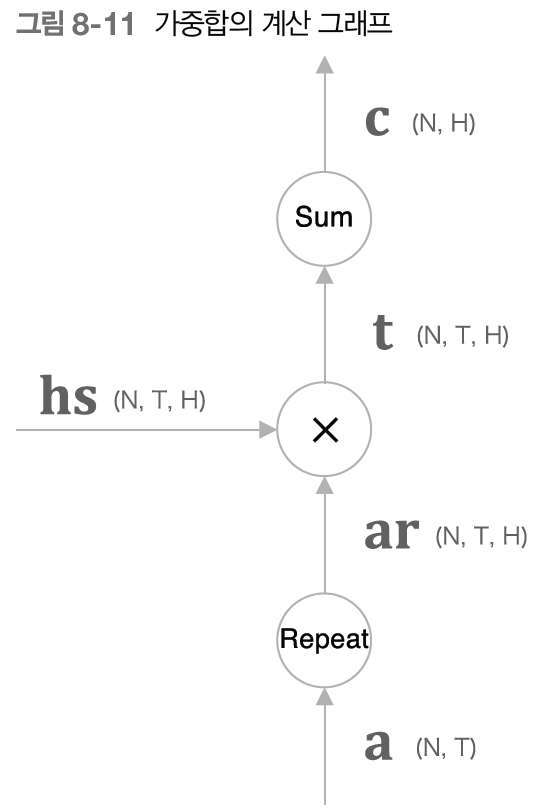
#### - Repeat의 역전파는 sum이고 sum의 역전파는 repeat

In [3]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
    def forward(self, hs, a):
        N, T, H = hs.shape
        ar = a.reshape(N, T, 1).repeat(H, axis=2)
        t = hs*ar
        c=np.sum(t, axis=1)
        self.cahce = (hs, ar)
        return c
    
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt *hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)
        
        return dhs, da

#### 8.1.4 Decoder 개선 2
#### - 맥락벡터 계산을 위해 필요한 가중치 a 구하는 방법
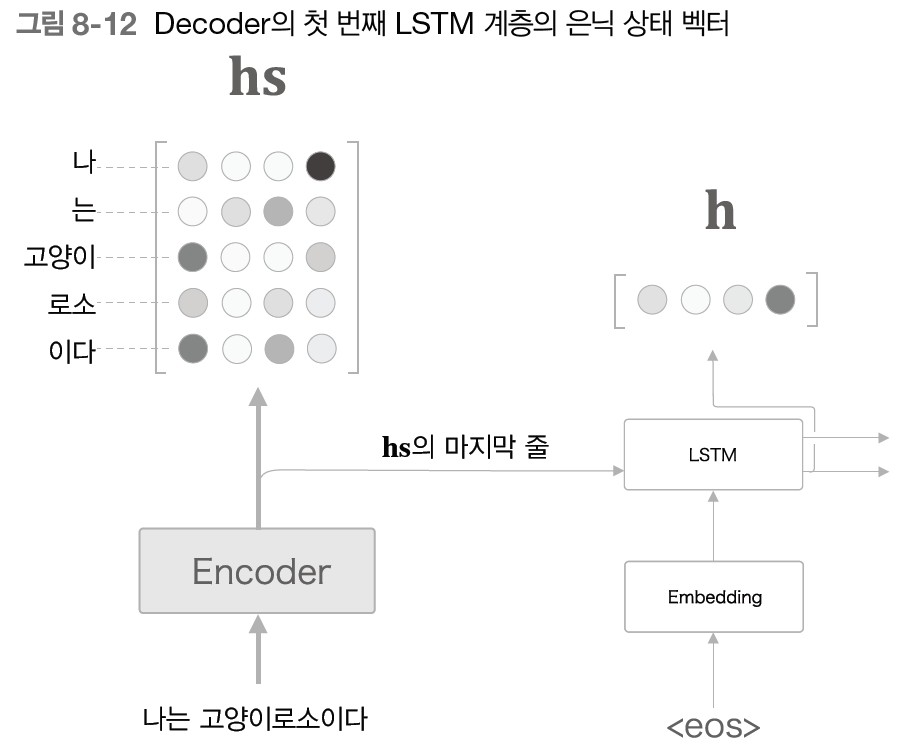
#### - Decoder의 LSTM 계층의 은닉 상태 벡터 h와 hs의 각 던어 벡터와 얼마나 비슷한가를 수치로 표현하는 것이 필요 -> 내적 활용
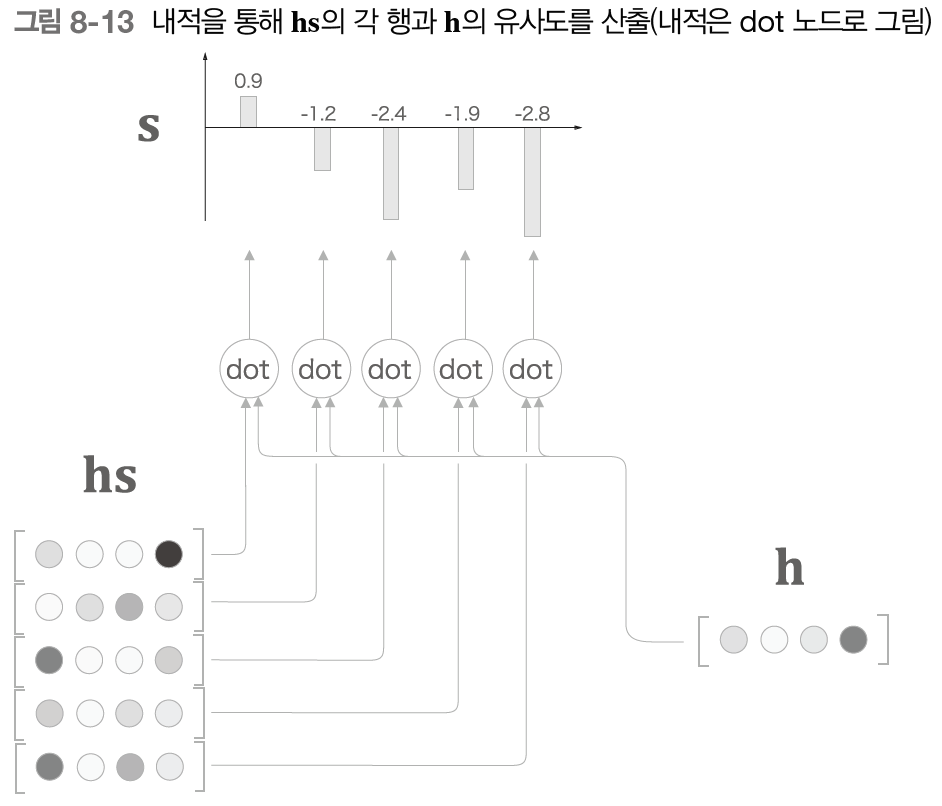
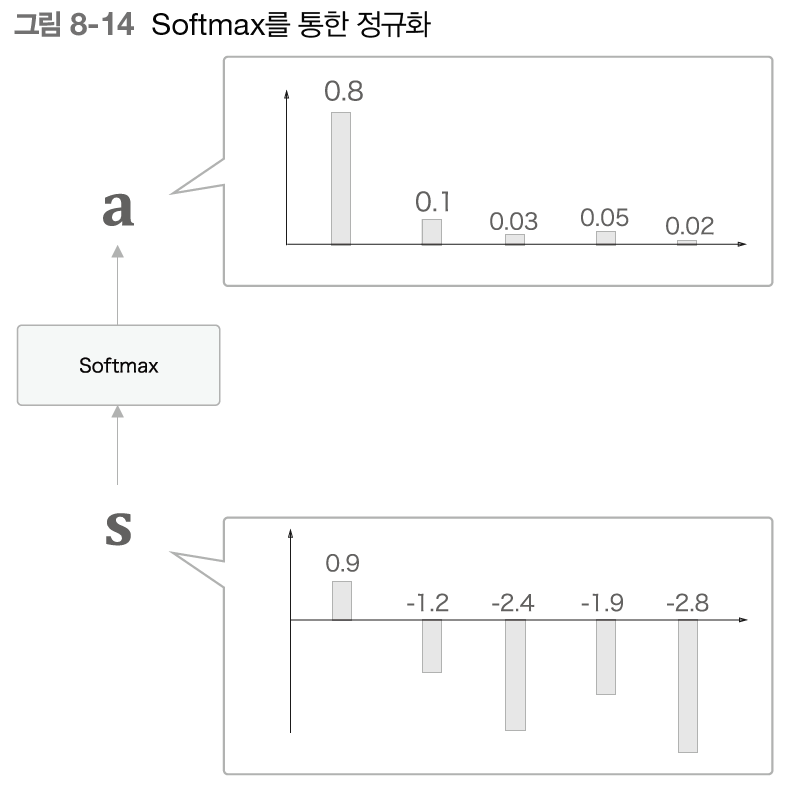
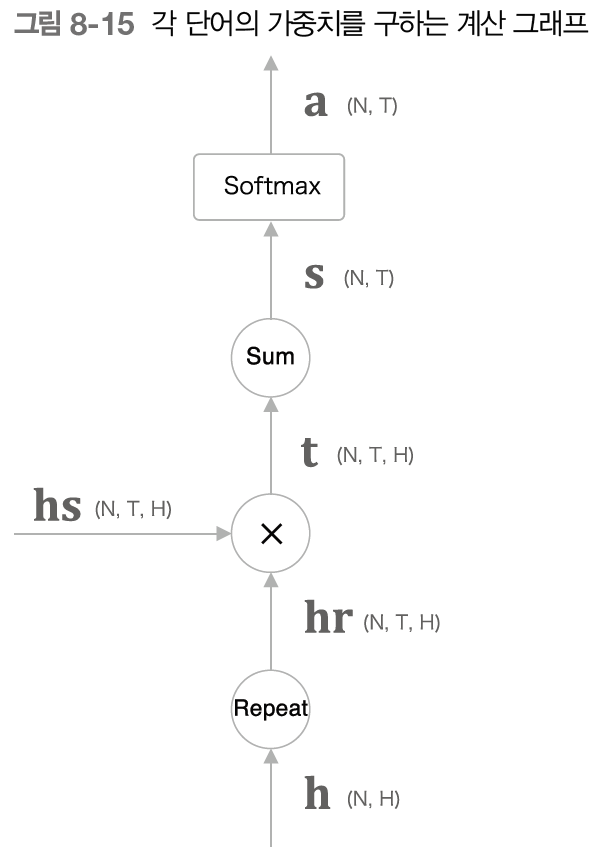

#### 8.1.5 Decoder 개선 3
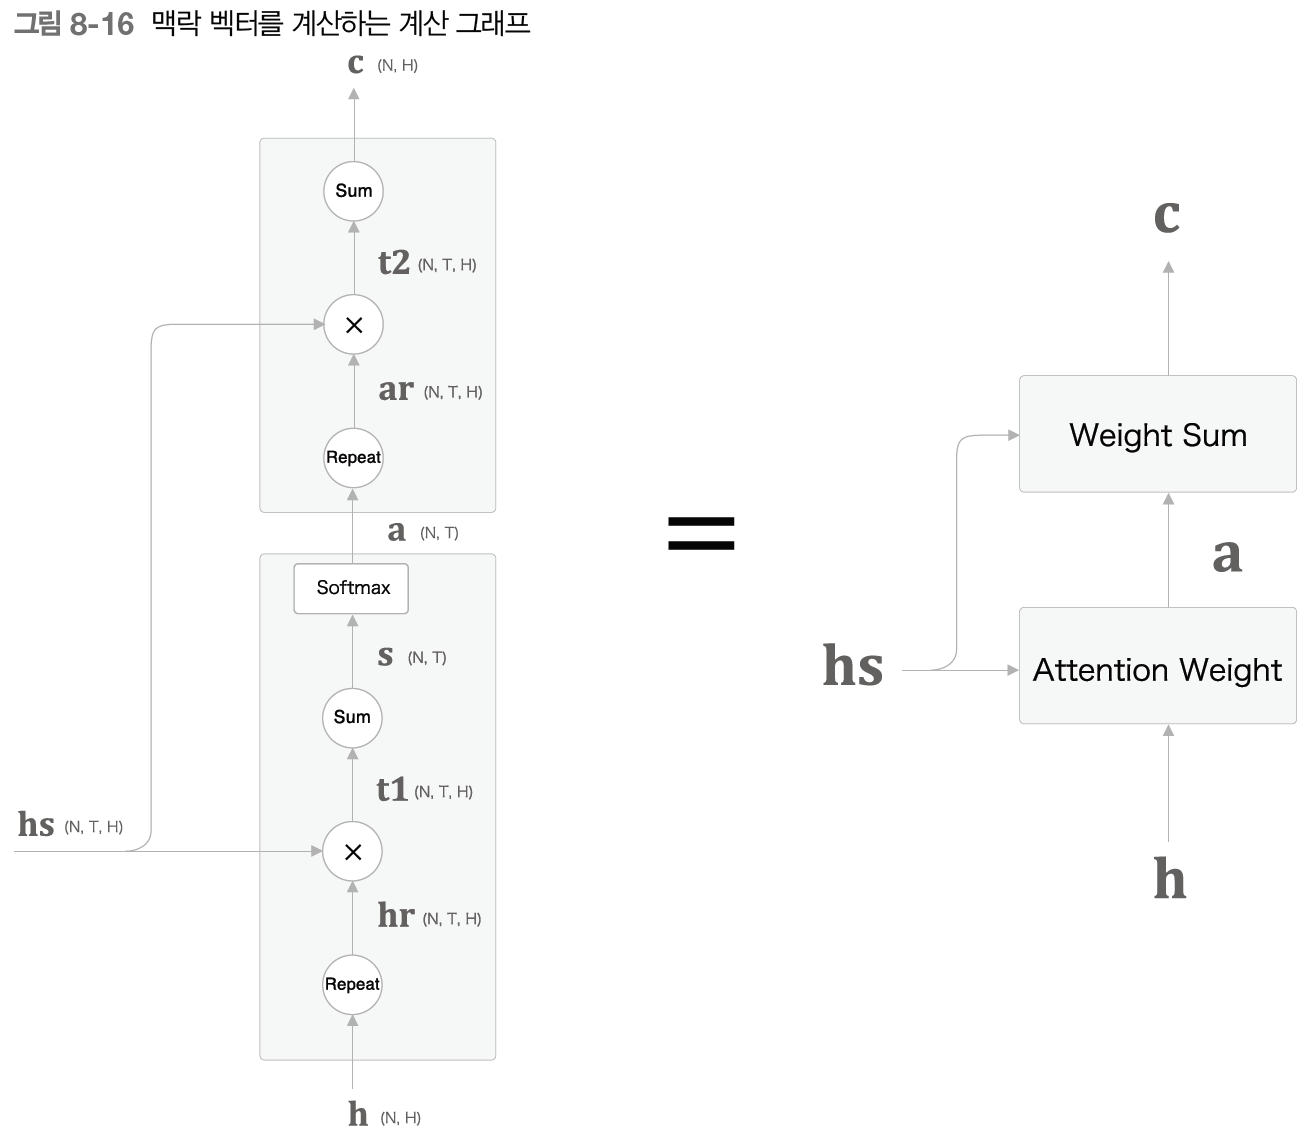
#### - attention 계층 = Weight sum 계층(a와 hs의 가중합을 구한 후 결과를 맥락 벡터 c로 출력) + Attention weight 계층(Encoder가 출력하는 각 단어 벡터 hs에 주목하여 해당 단어의 가중치 a를 구함)
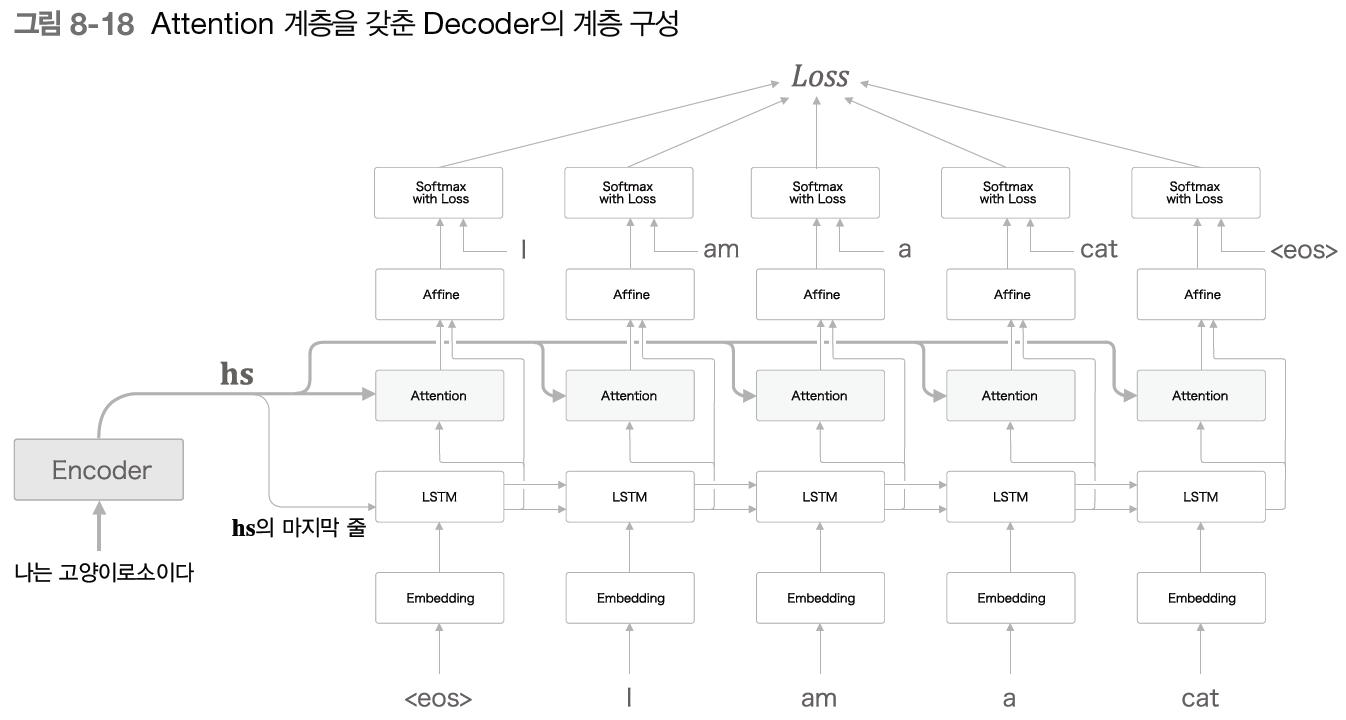
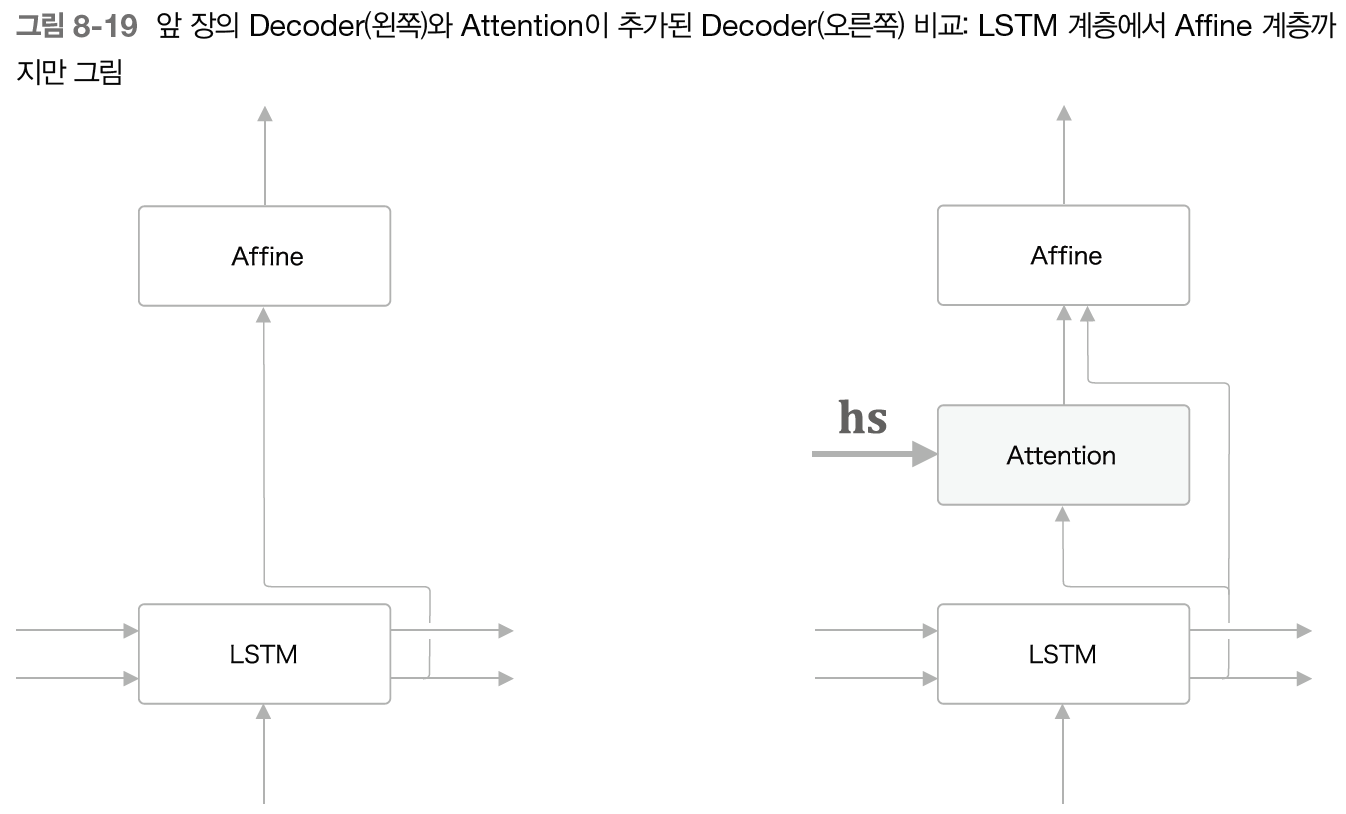

### 8.2 어텐션을 갖춘 seq2seq 구현
#### 8.2.1 Encoder 구현
#### - 모든 은닉 상태를 반환할 수 있도록 수정
#### 8.2.2 Decoder 구현
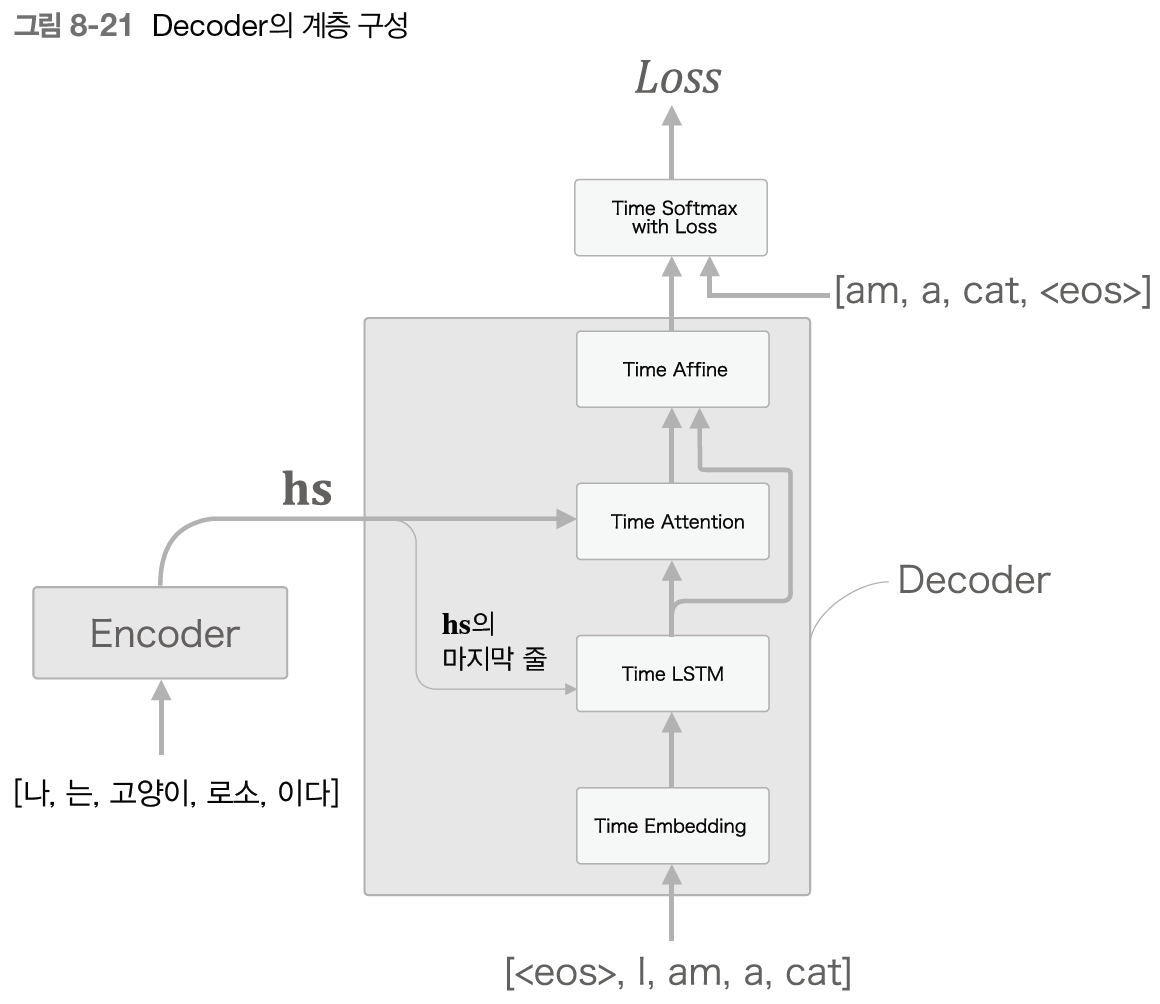
#### 8.2.3 seq2seq 구현
#### - Encoder대신 AttentionEncoder, Decoder 대신 AttentionDecoder 활용

### 8.3 어테션 평가
#### 8.3.1 날짜 형식 변환 문제
#### 8.3.2 어텐션을 갖춘 seq2seq 학습
#### 8.3.3 어텐션 시각화
#### - 어텐션이 시계열 변환을 수행할 떄, 어느 원소에 주의를 기울이는 지 시각적으로 확인
#### - 각 시각의 어텐션 가중치 변수를 활용하여 시각화
#### - 일반적인 신경망 내부의 처리는 인간이 이해할 수 없는 것이 일반적이지만, 어텐션은 인간이 이해할 수 있는 구조나 의미를 모델에 제공

### 8.4 어텐션에 관한 남은 이야기
#### 8.4.1 양방향 RNN
#### - LSTM을 양방향으로 처리하는 방법
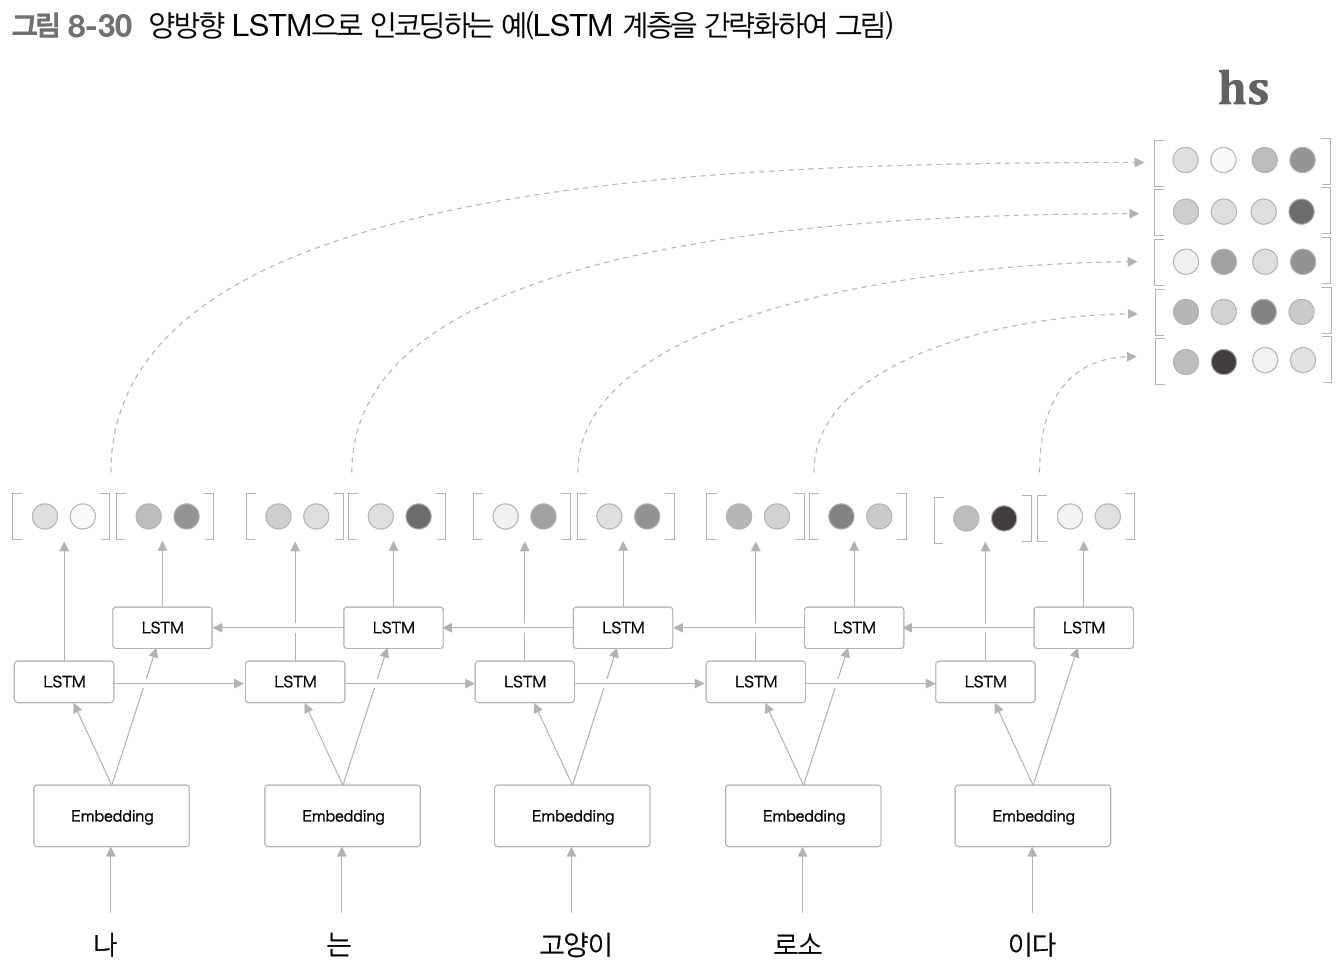
#### - 각 시각의 은닉 상태는 두 개의 LSTM 계층의 은닉 상태를 연결시켜 출력
#### - 양방향으로 처리함으로써 각 단어에 대응하는 은닉 상태 벡터에는 좌, 우 양쪽 방향의 정보 집약 가능
#### 8.4.2 Attention 계층 사용 방법
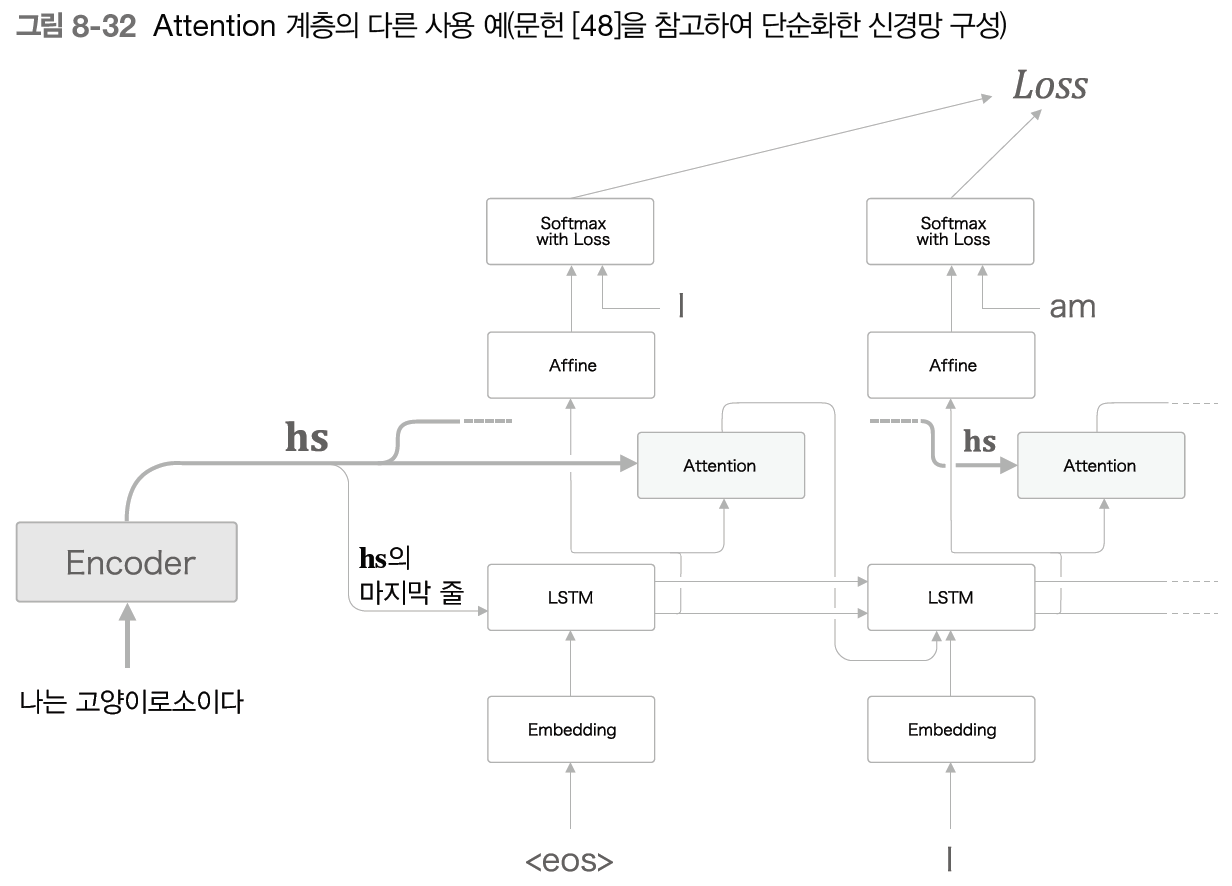
#### 8.4.3 seq2seq 심층화와 skip 연결
#### - RNN 계층을 깊게 쌓음 -> 표현력 높은 모델 생성 가능
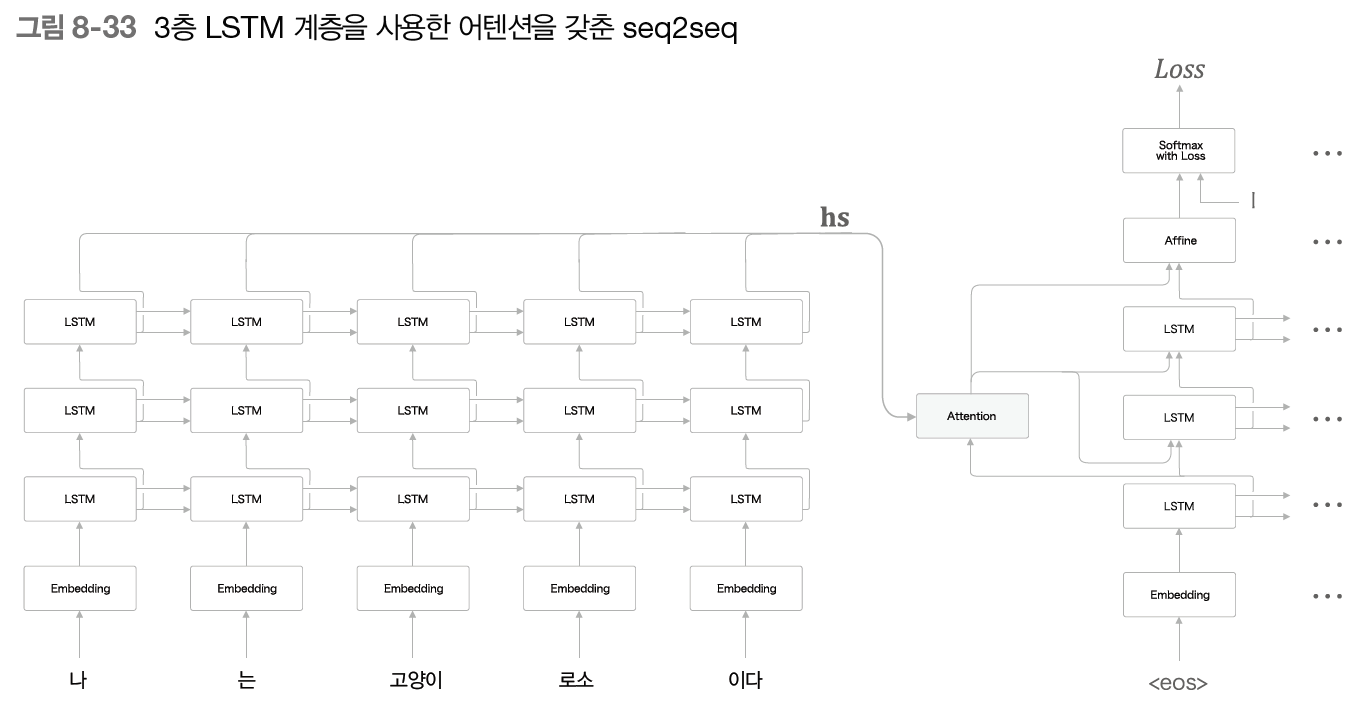
#### - Encoder와 Decoder의 LSTM 계층은 동일한 갯수 활용하는 것이 일반적
#### - skip 연결 : 계층을 넘어 연결하는 기법
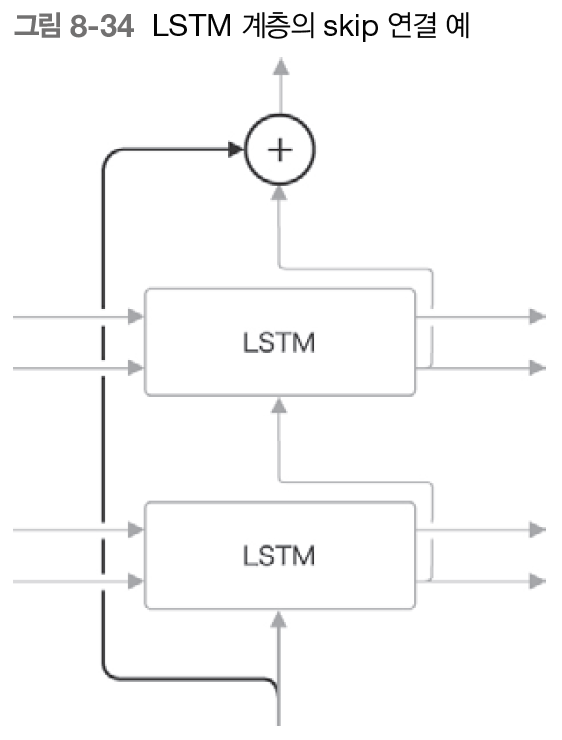
#### - skip 연결의 접속부에서는 2개의 출력이 더해짐 -> 덧셈은 역전파 시 기울기를 그대로 흘리기 때문에 skip 연결의 기울기가 아무런 영향을 받지 않고 모든 계층으로 흐름 -> 층이 깊어져도 기울기가 소실 혹은 폭발하지 않고 전파되어 좋은 학습 가능

### 8.5 어텐션 응용
#### 8.5.1 구글 신경망 기계 번역(GNMT)
#### - 기계 번역의 역사 : 규칙 기반 번역 -> 용례 기반 번역 -> 통계 기반 번역 -> 신경망 기계 변역(NMT) == seq2seq를 사용한 기계 번역의 총칭
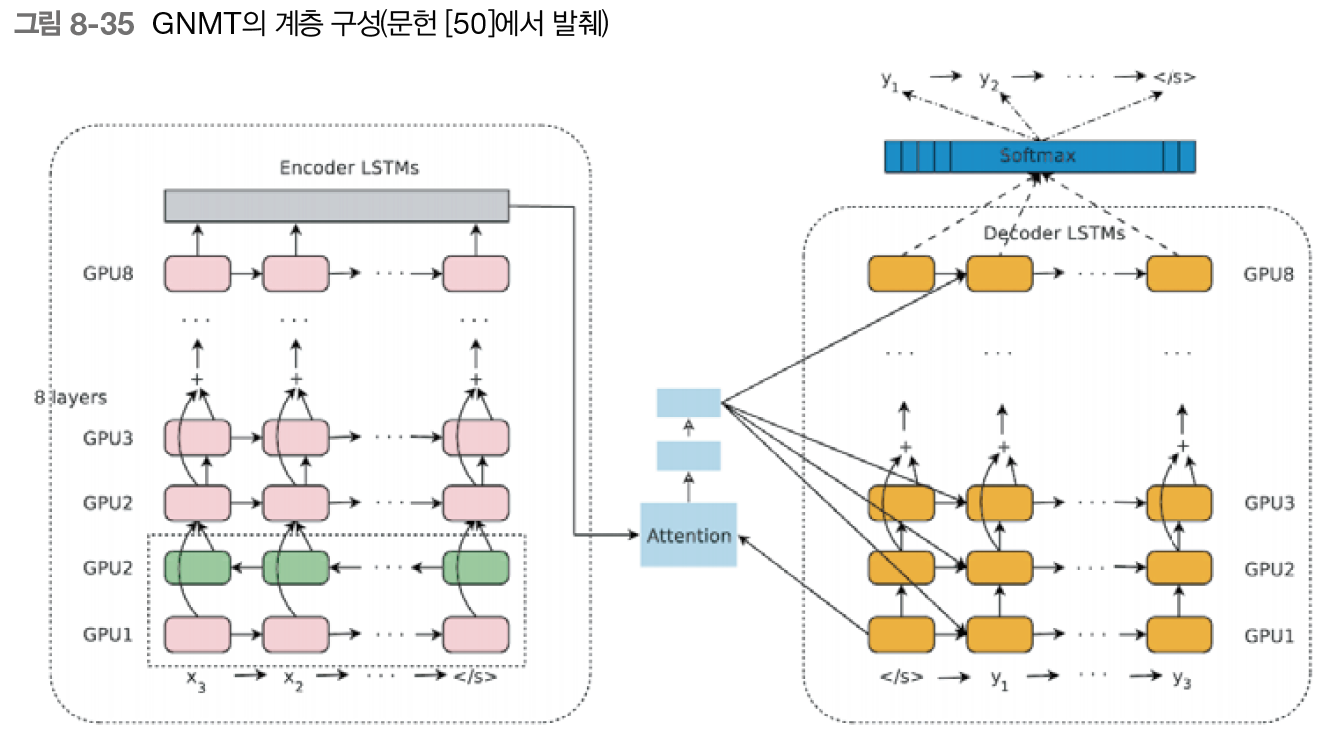
#### - Encoder, Decoder, Attention, LSTM계층의 다양화, 양방향 LSTM, skip 연결, GPU 분산 학습, 낮은 빈도 단어 처리나 추론 고속화를 위한 양자화
#### 8.5.2 트랜스포머
#### - RNN의 단점 : 병렬처리가 불가능(이전 시각에 계산한 결과를 이용하여 순서대로 계산해야 하기 때문)
#### - 트랜스포머 : 셀프어텐션 활용 -> 하나의 시계열 데이터를 대상으로 한 어텐션으로, 하나의 시계열 데이터 내에서 각 원소가 다른 원소들과 어떻게 관련되는 지 파악
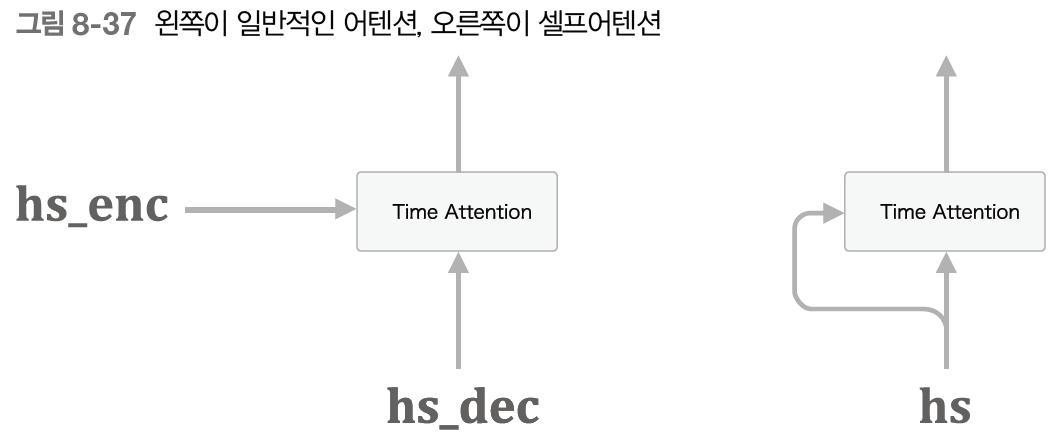
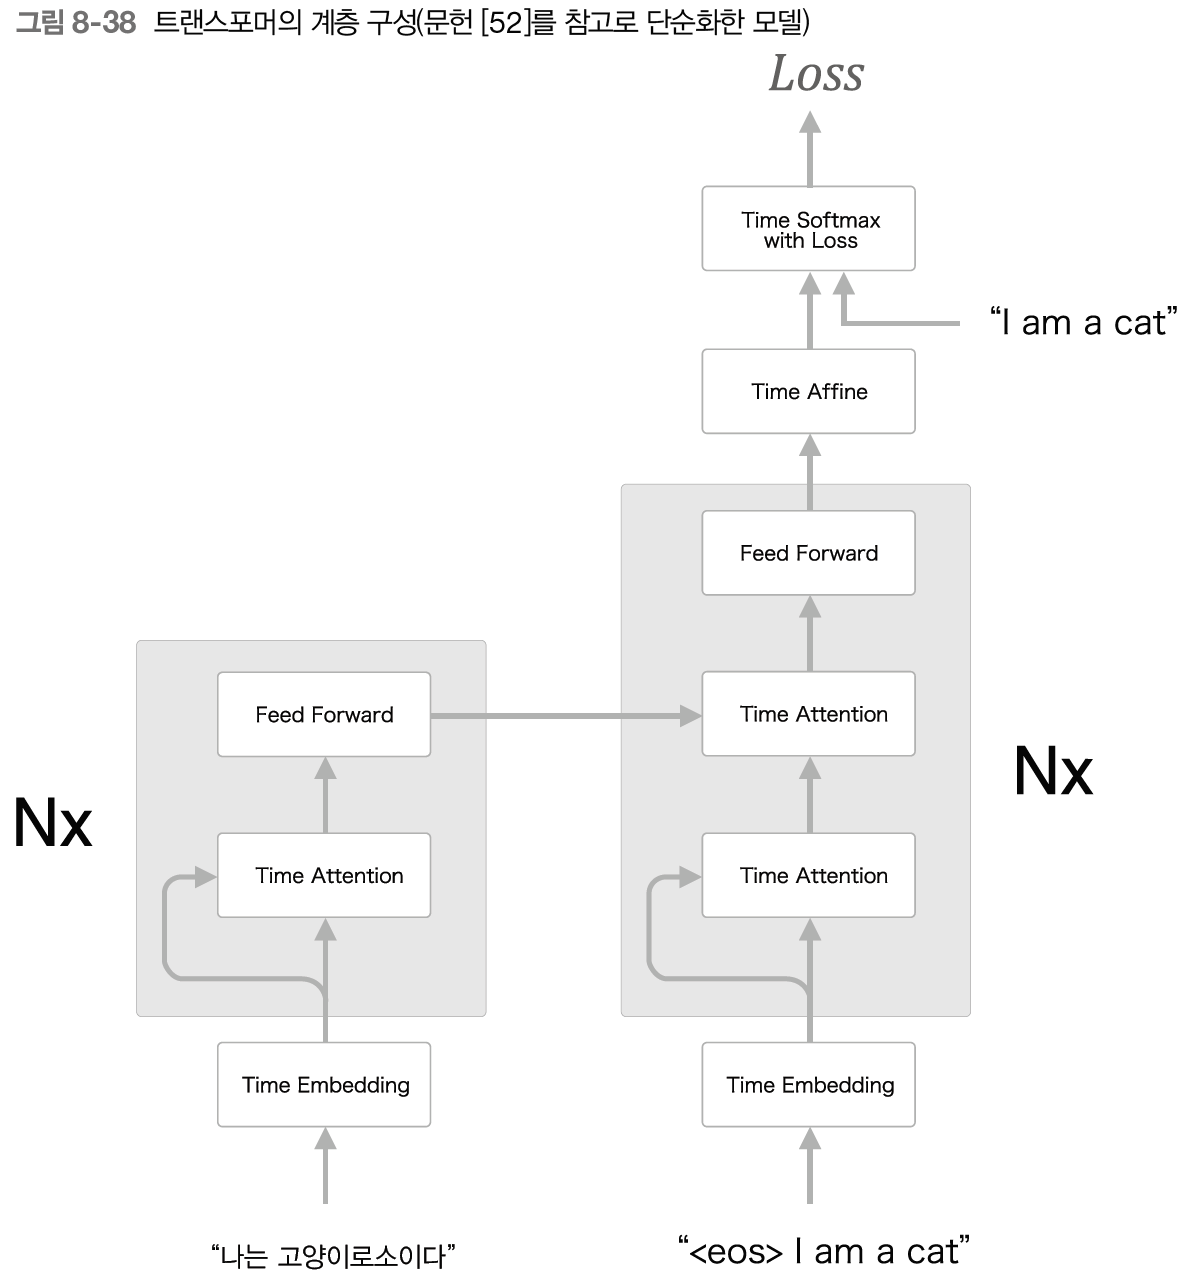
#### - 트랜스포머에서는 RNN 대신 어텐션을 사용, Feed forward 계층(은닉층 1개 + ReLu를 사용한 완전연결계층 신경망) 활용, skip 연결 활용, 계층 정규화 이용
#### 8.5.3 뉴럴 튜링 머신(NTM)
#### - RNN의 외부에 정보 저장용 메모리 기능을 배치하고, 어텐션을 이용하여 그 메모리로부터 필요한 정보를 읽거나 쓰는 방법
#### - NTM은 외부 메모리를 읽고 쓰면서 시계열 데이터를 처리
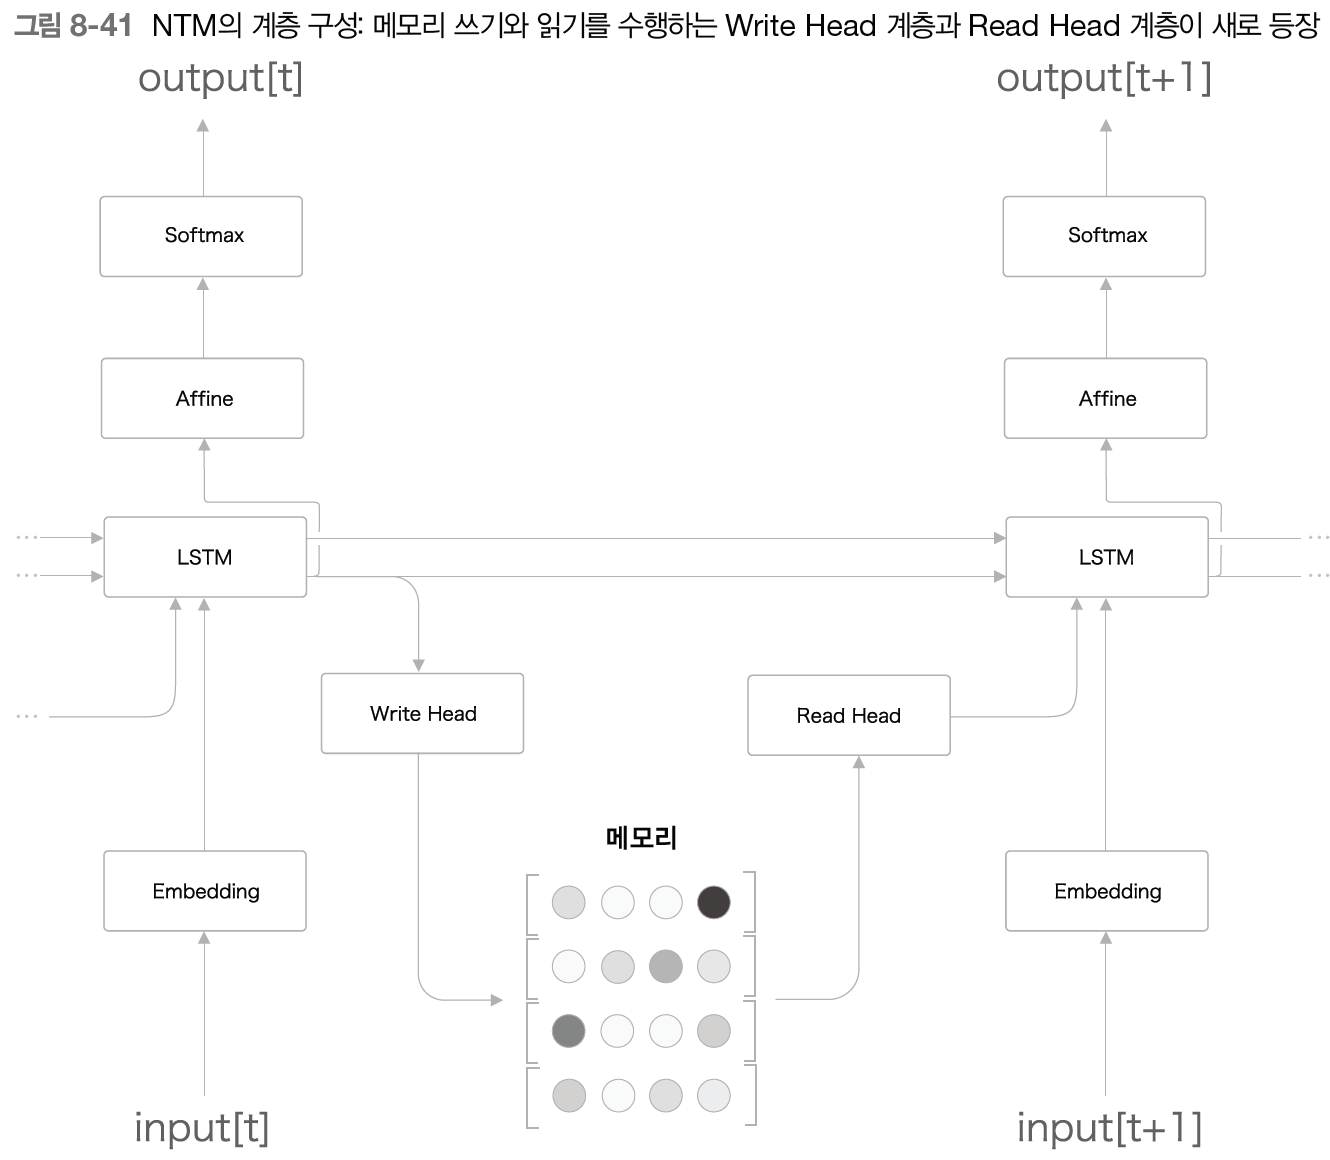
